# Notebook for Unsupervised ML: Detecting conservation laws

- Code taken and adapted from: https://github.com/KindXiaoming/aipoincare/blob/master/backend/training.py
- Dataset from: https://github.com/KindXiaoming/aipoincare/blob/master/backend/data/oned_harmonic
- ChatGPT assistance (30 Sept 2025)

## Set up working tree and load packages

In [17]:
# --------------------- Import necessary libraries ---------------------
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
from sklearn.decomposition import PCA
import torch.optim as optim
import copy

# set seeds to make outputs reproducible
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [18]:
# --------------------- Set hyperparameters and data config ---------------------

# Hidden layer widths for the neural network; first and last layer are added later
nn_widths = [256, 256]  # Two hidden layers: 64 units and 32 units
hidden_depth = len(nn_widths)
# Negative slope for LeakyReLU activation function
slope = 0.1
# List of noise magnitudes (sigmal) to test during training
sigmals = [1e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1.0, 10.0]
# Optimizer type: 'Adam' or 'SGD'
opt = 'Adam'
# Learning rate for optimizer
lr = 0.001
# Mini-batch size for training
batch_size = 64
# Number of training iterations (epochs)
epoch = 5000
# ERD parameter `a` for computing effective dimensionality
a = 2
# Path to the input data file (must be a .txt file of shape [n_samples, n_features])
model = 'harmonic_1d.txt'
# Number of random walks to simulate for post-training variance analysis
n_walk = 600

[[ 0.          1.        ]
 [ 1.          0.95      ]
 [ 1.9         0.805     ]
 ...
 [ 2.04622222 -0.76926265]
 [ 1.17464845 -0.93030619]
 [ 0.18560984 -0.9983191 ]] 1000 2


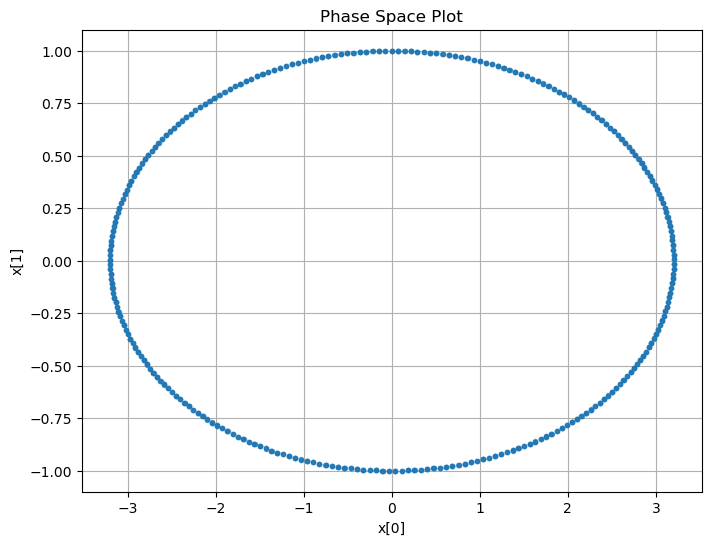

In [19]:
# --------------------- Load and preprocess the data ---------------------

# Load dataset as NumPy array
xs = np.loadtxt(model)
n_train = xs.shape[0]       # Number of samples
input_dim = xs.shape[1]     # Dimensionality of input features

# Show data set and plot phase space
print( xs, n_train, input_dim )

plt.figure(figsize=(8, 6))
plt.plot(xs[:, 0], xs[:, 1], '.', alpha=0.6)
plt.title("Phase Space Plot")
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.grid(True)
plt.show()

In [20]:
# Step 1: Normalize each input feature to zero mean and unit variance
xs = (xs - np.mean(xs, axis=0)[np.newaxis, :]) / np.std(xs, axis=0)[np.newaxis, :]

# Sanity check that mean = 0, and std = 1
np.round(xs.mean(axis=0),3), np.round(xs.std(axis=0),3)

(array([ 0., -0.]), array([1., 1.]))

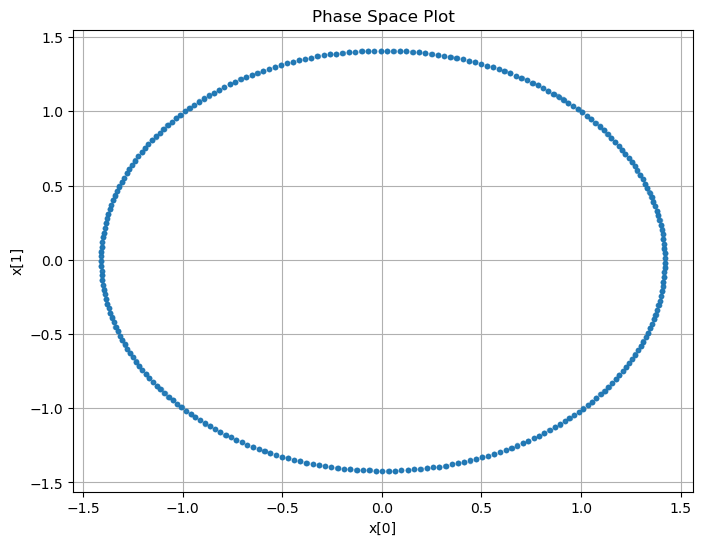

In [21]:
# Step 2: Apply PCA (rotation only, no scaling) to decorrelate dimensions
pca = PCA()
xs = pca.fit_transform(xs)

# Plot transformed data
plt.figure(figsize=(8, 6))
plt.plot(xs[:, 0], xs[:, 1], '.', alpha=0.6)
plt.title("Phase Space Plot")
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.grid(True)
plt.show()

In [22]:
# Build the entire hidden dimensions of the NN:
nn_widths.insert(0, input_dim)
nn_widths.append(input_dim)
print( nn_widths )

[2, 256, 256, 2]


## Training

In [24]:
# --------------------- Training loop across different noise levels ---------------------
exps = []   # To store explained variance ratios
losses = [] # To record loss values during training

for sigmal in sigmals:
    # Define a new neural network (as a list of layers) for each noise level
    linears = [nn.Linear(nn_widths[i], nn_widths[i + 1]) for i in range(hidden_depth + 1)]
    parameters = [p for layer in linears for p in layer.parameters()]  # Collect all trainable parameters

    # Define loss function
    criterion = nn.MSELoss()

    # Choose optimizer
    optimizer = optim.Adam(parameters, lr=lr) if opt == "Adam" else optim.SGD(parameters, lr=lr)

    print(f"sigmal = {sigmal}")

    # --------------------- Training the denoising network ---------------------
    # (see in the Appendix below a step by step explanation of these steps)
    
    for j in range(epoch):
        # Randomly sample a batch of training data
        choices = np.random.choice(n_train, batch_size)
        perturb = torch.normal(0, sigmal, size=(batch_size, input_dim))  # Add Gaussian noise
        inputs0 = torch.tensor(xs[choices], dtype=torch.float) + perturb  # Noisy input

        # Forward pass through each layer using LeakyReLU
        x = inputs0
        act = nn.LeakyReLU(slope)
        for i in range(hidden_depth):
            x = act(linears[i](x))
        outputs = linears[hidden_depth](x)  # Final layer (no activation)

        # Training objective: recover the *negative* of the noise added
        loss = criterion(outputs, -perturb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(float(loss.data))

        if j % 200 == 0:
            print(f"Epoch {j} | Loss: {loss:.4f}")

    # --------------------- Perform stochastic walks using trained network ---------------------
    x0 = copy.deepcopy(xs[int(n_train / 2)])  # Start from a central data point
    x0 = x0[np.newaxis, :]
    x0 = x0 + np.random.randn(n_walk, input_dim) * sigmal  # Add noise

    # Pass walk samples through trained denoising network
    x = torch.tensor(x0, dtype=torch.float)
    for i in range(hidden_depth):
        x = act(linears[i](x))
    x = linears[hidden_depth](x)
    x0 = x0 + x.detach().numpy()  # Apply learned correction

    # --------------------- Compute explained variance ratio via PCA ---------------------
    pca = PCA()
    pca.fit(x0)
    svs = pca.singular_values_
    exp_ratio = svs**2 / np.sum(svs**2)
    exps.append(exp_ratio)

# Stack results into a NumPy array
exps = np.array(exps)

sigmal = 0.001
Epoch 0 | Loss: 0.0222
Epoch 200 | Loss: 0.0000
Epoch 400 | Loss: 0.0000
Epoch 600 | Loss: 0.0000
Epoch 800 | Loss: 0.0000
Epoch 1000 | Loss: 0.0000
Epoch 1200 | Loss: 0.0000
Epoch 1400 | Loss: 0.0000
Epoch 1600 | Loss: 0.0000
Epoch 1800 | Loss: 0.0000
Epoch 2000 | Loss: 0.0000
Epoch 2200 | Loss: 0.0000
Epoch 2400 | Loss: 0.0000
Epoch 2600 | Loss: 0.0000
Epoch 2800 | Loss: 0.0000
Epoch 3000 | Loss: 0.0000
Epoch 3200 | Loss: 0.0000
Epoch 3400 | Loss: 0.0000
Epoch 3600 | Loss: 0.0000
Epoch 3800 | Loss: 0.0000
Epoch 4000 | Loss: 0.0000
Epoch 4200 | Loss: 0.0000
Epoch 4400 | Loss: 0.0000
Epoch 4600 | Loss: 0.0000
Epoch 4800 | Loss: 0.0000
sigmal = 0.01
Epoch 0 | Loss: 0.0063
Epoch 200 | Loss: 0.0001
Epoch 400 | Loss: 0.0001
Epoch 600 | Loss: 0.0001
Epoch 800 | Loss: 0.0001
Epoch 1000 | Loss: 0.0001
Epoch 1200 | Loss: 0.0001
Epoch 1400 | Loss: 0.0001
Epoch 1600 | Loss: 0.0001
Epoch 1800 | Loss: 0.0001
Epoch 2000 | Loss: 0.0001
Epoch 2200 | Loss: 0.0001
Epoch 2400 | Loss: 0.00

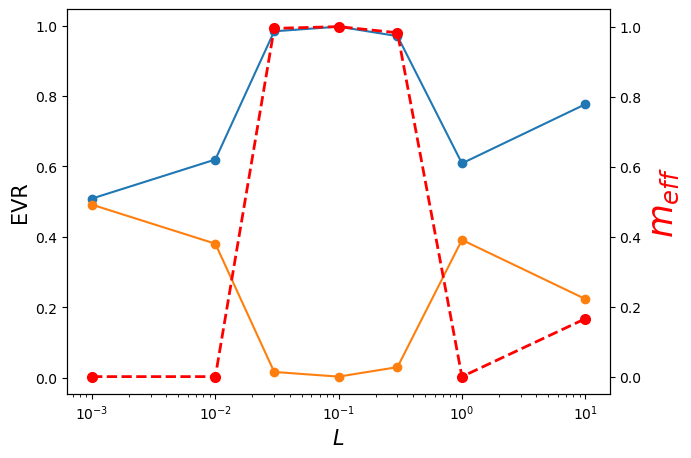

<Figure size 640x480 with 0 Axes>

In [25]:
# --------------------- Define helper function to compute effective rank (ERD) ---------------------
def f(x, a=2):
    n = x.shape[1]
    mask = x < 1 / (a * n)
    return np.sum(np.cos(np.pi / 2 * n * a * x) * mask, axis=1)

# --------------------- Plot explained variance and effective dimensionality ---------------------
plt.figure(figsize=(7, 5))

# Plot each PCA component’s explained variance
for i in range(input_dim):
    plt.plot(sigmals, exps[:, i], marker="o")

plt.xscale('log')
plt.xlabel(r"$L$", fontsize=15)
plt.ylabel("EVR", fontsize=15)

# Plot effective dimensionality (ERD) on second y-axis
ax2 = plt.gca().twinx()
ax2.plot(sigmals, f(exps, a=2), marker="o", color="red", linewidth=2, ls="--", markersize=7)
plt.ylabel(r"$m_{eff}$", fontsize=25, color="red")

# Save the plot to disk
plt.savefig('ERD.png', bbox_inches="tight")

plt.show()
plt.clf()

## Appendix:

In [27]:
# Define a new neural network (as a list of layers) for each noise level
linears = [nn.Linear(nn_widths[i], nn_widths[i + 1]) for i in range(hidden_depth + 1)]
parameters = [p for layer in linears for p in layer.parameters()]  # Collect all trainable parameters

# Define loss function
criterion = nn.MSELoss()

# Choose optimizer
optimizer = optim.Adam(parameters, lr=lr) if opt == "Adam" else optim.SGD(parameters, lr=lr)

sigmal = .1
epoch = 1000

# --------------------- Training the denoising network ---------------------
# (see in the Appendix below a step by step explanation of these steps)

for j in range(epoch):
    # Randomly sample a batch of training data
    choices = np.random.choice(n_train, batch_size)
    perturb = torch.normal(0, sigmal, size=(batch_size, input_dim))  # Add Gaussian noise
    inputs0 = torch.tensor(xs[choices], dtype=torch.float) + perturb  # Noisy input

    # Forward pass through each layer using LeakyReLU
    x = inputs0
    act = nn.LeakyReLU(slope)
    for i in range(hidden_depth):
        x = act(linears[i](x))
    outputs = linears[hidden_depth](x)  # Final layer (no activation)

    # Training objective: recover the *negative* of the noise added
    loss = criterion(outputs, -perturb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if j % 200 == 0:
        print(f"Epoch {j} | Loss: {loss:.4f}")

Epoch 0 | Loss: 0.0110
Epoch 200 | Loss: 0.0055
Epoch 400 | Loss: 0.0068
Epoch 600 | Loss: 0.0056
Epoch 800 | Loss: 0.0066


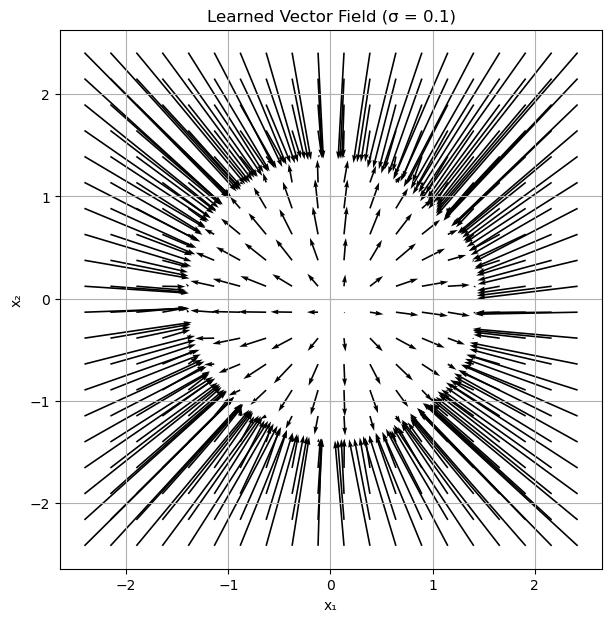

In [41]:
# Only do vector field visualization for 2D input

# Create a 2D grid of points over the range of training data
grid_size = 20
x_min, x_max = xs[:, 0].min() - 1, xs[:, 0].max() + 1
y_min, y_max = xs[:, 1].min() - 1, xs[:, 1].max() + 1
x_vals = np.linspace(x_min, x_max, grid_size)
y_vals = np.linspace(y_min, y_max, grid_size)
xv, yv = np.meshgrid(x_vals, y_vals)
grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)

# Pass grid points through network to get denoising vectors
with torch.no_grad():
    inputs = torch.tensor(grid_points, dtype=torch.float)
    x = inputs.clone()
    for i in range(hidden_depth):
        x = act(linears[i](x))
    outputs = linears[hidden_depth](x)

    # The output is the estimated negative noise → shows how the network would move the point
    vectors = outputs.numpy()

# Plot vector field
plt.figure(figsize=(7, 7))
plt.quiver(grid_points[:, 0], grid_points[:, 1], vectors[:, 0], vectors[:, 1], angles='xy', scale_units='xy', scale=1, width=0.003)
plt.title(f"Learned Vector Field (σ = {sigmal})")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.axis("equal")
plt.grid(True)

# Save to file
plt.savefig("vector_field.png", dpi=300, bbox_inches="tight")

# Show on screen
plt.show()

### More details on ANN processing

In [17]:
sigmal = 0.1

# Define a new neural network (as a list of layers) for each noise level
linears = [nn.Linear(nn_widths[i], nn_widths[i + 1]) for i in range(hidden_depth + 1)]
parameters = [p for layer in linears for p in layer.parameters()]  # Collect all trainable parameters

In [18]:
# Display parameter structure of ANN:
linears

[Linear(in_features=2, out_features=256, bias=True),
 Linear(in_features=256, out_features=256, bias=True),
 Linear(in_features=256, out_features=2, bias=True)]

In [25]:
# Define loss function
criterion = nn.MSELoss()

# Choose optimizer
optimizer = optim.Adam(parameters, lr=lr) if opt == "Adam" else optim.SGD(parameters, lr=lr)

print(f"sigmal = {sigmal}")

sigmal = 0.1


In [26]:
# --------------------- Training the denoising network ---------------------
# Randomly sample a batch of training data
choices = np.random.choice(n_train, batch_size)
perturb = torch.normal(0, sigmal, size=(batch_size, input_dim))  # Add Gaussian noise
inputs0 = torch.tensor(xs[choices], dtype=torch.float) + perturb  # Noisy input

print( f"Random indices: {choices}")
print( f"Mean of perturbation: {torch.mean(perturb,axis=0)}")
print( f"Std of perturbation: {torch.std(perturb,axis=0)}")

Random indices: [969 582 105 420 769 881 863 440 401  86  81 850 591 169 128 654 714 234
  48 174 785 873  66 543 529 672 496   9 478 151 891 345 793  30 418 115
 360 205 969 580 333 998  30 670 890 624 662  99  56 313 297 676 149 632
 649 204 907 375 499 545  96 957 659 792]
Mean of perturbation: tensor([ 0.0122, -0.0164])
Std of perturbation: tensor([0.0973, 0.0992])


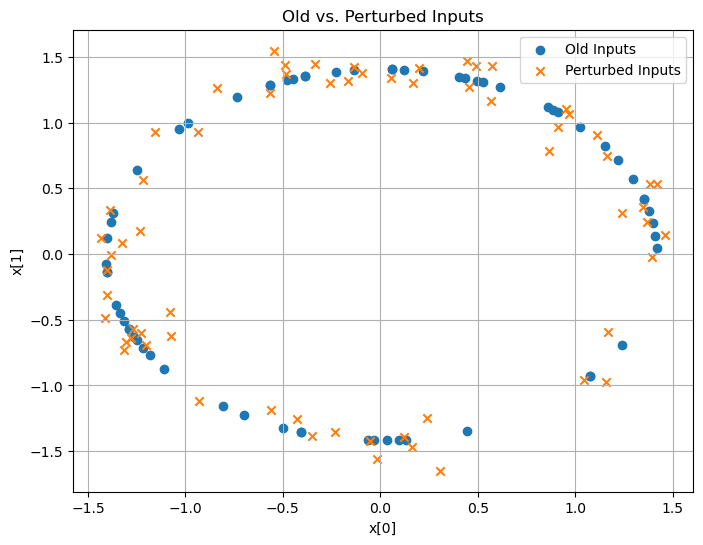

In [178]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(xs[choices][:, 0], xs[choices][:, 1], label='Old Inputs', marker='o')
plt.scatter(inputs0[:, 0], inputs0[:, 1], label='Perturbed Inputs', marker='x')
plt.title("Old vs. Perturbed Inputs")
plt.xlabel("x[0]")
plt.ylabel("x[1]")
plt.legend()
plt.grid(True)
plt.show()

LeakyReLU (activation function) allows for $x<0$ small gradients according to:
$f(x) = 
\begin{cases}
x & \text{if } x > 0 \\
\text{slope} \cdot x & \text{if } x \leq 0
\end{cases}$

In the following, linear transformations with non-linear activation (LeakyReLU), $\sigma$ are applied:
$x \rightarrow \sigma( Wx + b ) $

In [199]:
# Forward pass through each layer using LeakyReLU
x = inputs0
act = nn.LeakyReLU(slope)

# Now iterate through all layers:
for i in range(hidden_depth):
    x = act(linears[i](x))
outputs = linears[hidden_depth](x)  # Final layer (no activation)
outputs.shape

torch.Size([64, 2])

In [203]:
# Training objective: recover the *negative* of the noise added
loss = criterion(outputs, -perturb)
# Compute the loss between the model's outputs and the negative perturbations.
# This encourages the model to learn a vector field that points back toward the original (clean) inputs.

optimizer.zero_grad()
# Clear previous gradients to prevent accumulation from earlier backward passes.

loss.backward()
# Backpropagate the loss to compute gradients of the model parameters w.r.t. the loss.

optimizer.step()
# Update the model's parameters using the optimizer (here: Adam).

float(loss.data)
# Record the scalar loss value for monitoring or plotting training progress.

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.